In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
# Load preprocessed data
data = pd.read_csv('../data/bugs_preprocessed.csv')

In [3]:
# I will use the only text as feature
X = data['text_processed']
y = data['severity_category']

In [4]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print(f"Development set: {len(X_train)} samples")
print(f"Test set (holdout): {len(X_test)} samples")

Development set: 7998 samples
Test set (holdout): 2000 samples


In [5]:
# TF-IDF with 1000 words and accept terms that have document frequency between 2 and 80% of total documents
tfidf = TfidfVectorizer(max_features = 1000, min_df = 2, max_df = 0.8)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.fit_transform(X_test)

print(f"TF-IDF matrix shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF matrix shape (test): {X_test_tfidf.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")

TF-IDF matrix shape (train): (7998, 1000)
TF-IDF matrix shape (test): (2000, 1000)
Number of features: 1000


In [6]:
# Define Stratified K-Fold strategy, since the class distribution are not even
# with more than 70% data is in Normal category
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [7]:
# Compare different models using cross-validation
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
}

In [8]:
# Cross-Validation process and pick the best model name
best_model_name = None
best_score = 0

for model_name, model in models.items():
    # Cross-Validation scores
    cv_scores = cross_val_score(
        model, X_train_tfidf, y_train, 
        cv=cv, 
        scoring='f1_weighted',  # Better for imbalanced classes
        n_jobs=-1
    )
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()

    print(f"\n{model_name}:")
    print(f"  F1-Score: {mean_score:.4f} (±{std_score:.4f})")
    print(f"  All folds: {cv_scores}")

    if mean_score > best_score:
        best_score = mean_score
        best_model_name = model_name
print(f"\nBest model from CV: {best_model_name} (F1={best_score:.4f})")


Naive Bayes:
  F1-Score: 0.6722 (±0.0018)
  All folds: [0.67199928 0.66990876 0.67055038 0.67346111 0.67488553]

Logistic Regression:
  F1-Score: 0.6928 (±0.0056)
  All folds: [0.68900949 0.69613996 0.69134893 0.68564983 0.70176111]

Random Forest:
  F1-Score: 0.6979 (±0.0039)
  All folds: [0.69527569 0.69589771 0.69893055 0.69412495 0.70507491]

Best model from CV: Random Forest (F1=0.6979)


In [9]:
# Train best model
best_model = models[best_model_name]
best_model.fit(X_train_tfidf, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
# Final evaluation with holdout test set
# Since the X_test has been transformed before, I am predicting it
y_pred = best_model.predict(X_test_tfidf)

In [11]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

     blocker       0.00      0.00      0.00        41
    critical       0.14      0.01      0.02       121
       major       0.00      0.00      0.00       148
       minor       0.00      0.00      0.00       108
      normal       0.76      0.99      0.86      1521
     trivial       0.00      0.00      0.00        61

    accuracy                           0.76      2000
   macro avg       0.15      0.17      0.15      2000
weighted avg       0.59      0.76      0.66      2000



D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [12]:
# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(y_test.value_counts())


Confusion Matrix:
[[   0    0    0    0   41    0]
 [   0    1    0    0  120    0]
 [   0    0    0    0  148    0]
 [   0    0    0    0  108    0]
 [   0    6    2    0 1511    2]
 [   0    0    0    0   61    0]]
severity_category
normal      1521
major        148
critical     121
minor        108
trivial       61
blocker       41
Name: count, dtype: int64


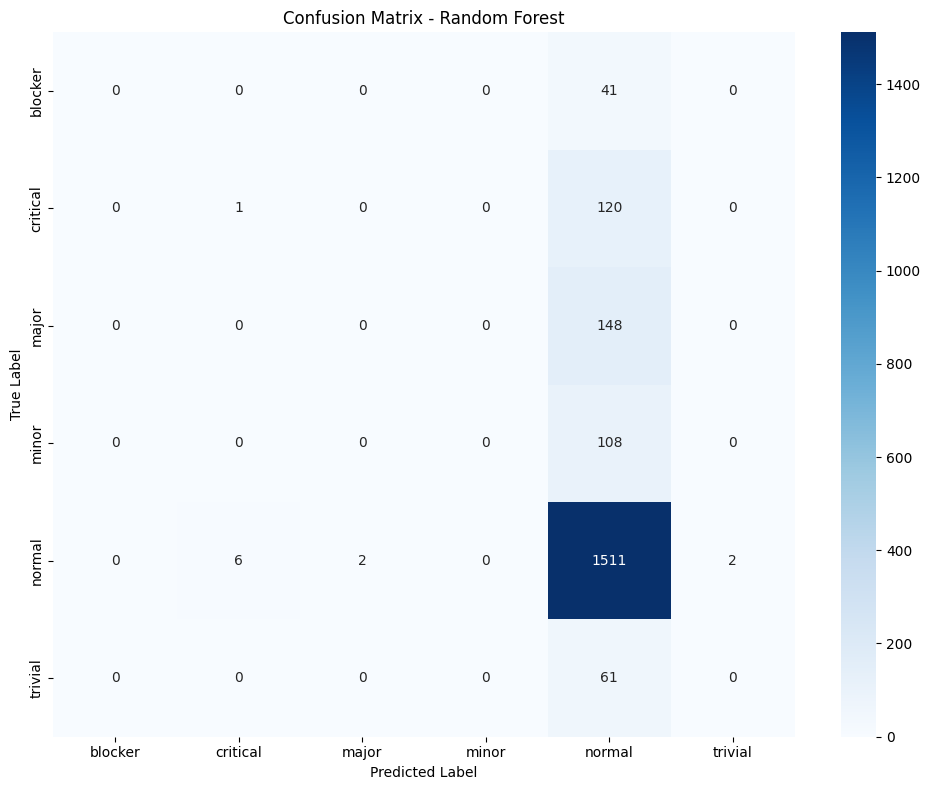

In [13]:
plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=sorted(y.unique()),
           yticklabels=sorted(y.unique()))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# End of test

In [15]:
# Since the result in the confusion matrix is so bad, I'll use another approach
# Add some categorical data as input and data resampling for imbalanced data with SMOTE
data['text_length'] = data['text_processed'].str.split().str.len()

X_text = data['text_processed']
X_cat = data[['component_name', 'product_name', 'text_length']]
y = data['severity_category']

print(f"\nData shape: {data.shape}")
print("\nClass distribution:")
print(y.value_counts())


Data shape: (9998, 23)

Class distribution:
severity_category
normal      7603
major        738
critical     606
minor        541
trivial      305
blocker      205
Name: count, dtype: int64


In [16]:
class FeatureCombiner(BaseEstimator, TransformerMixin):
    """Combine TF-IDF text features with categorical features"""
    
    def __init__(self, tfidf_params=None):
        self.tfidf_params = tfidf_params or {
            'max_features': 1000, 
            'min_df': 2, 
            'max_df': 0.8
        }
        self.tfidf = None
        self.encoder_component = None
        self.encoder_product = None
        
    def fit(self, X, y=None):
        # TF-IDF for text
        self.tfidf = TfidfVectorizer(**self.tfidf_params)
        self.tfidf.fit(X['text_processed'])
        
        # OrdinalEncoder handles unknown categories
        self.encoder_component = OrdinalEncoder(
            handle_unknown='use_encoded_value',  # Assign unknown to -1
            unknown_value=-1
        )
        self.encoder_component.fit(X[['component_name']])
        
        self.encoder_product = OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=-1
        )
        self.encoder_product.fit(X[['product_name']])
        
        return self
    
    def transform(self, X):
        # Transform text
        X_tfidf = self.tfidf.transform(X['text_processed'])
        
        # Transform categorical (handles unknown values)
        component_encoded = self.encoder_component.transform(X[['component_name']])
        product_encoded = self.encoder_product.transform(X[['product_name']])
        text_length = X['text_length'].values.reshape(-1, 1)
        
        # Combine all features
        X_combined = hstack([X_tfidf, component_encoded, product_encoded, text_length])
        
        return X_combined

In [17]:
# Combine text and categorical for splitting
X_combined_data = pd.DataFrame({
    'text_processed': X_text,
    'component_name': X_cat['component_name'],
    'product_name': X_cat['product_name'],
    'text_length': X_cat['text_length']
})

X_dev, X_test, y_dev, y_test = train_test_split(
    X_combined_data, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nDevelopment set: {len(X_dev)} samples")
print(f"Test set (holdout): {len(X_test)} samples")


Development set: 7998 samples
Test set (holdout): 2000 samples


In [18]:
# Let's test using K-fold with class weights first
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [19]:
# Models with class weights
models_weighted = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
}

# Custom scoring
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'f1_micro': make_scorer(f1_score, average='micro')
}

In [20]:
results_weighted = {}

for model_name, model in models_weighted.items():
    print(f"\n{model_name}:")
    
    # We need to manually do K-fold because we need to transform features in each fold
    f1_macro_scores = []
    f1_weighted_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_dev, y_dev), 1):
        # Split data
        X_train_fold = X_dev.iloc[train_idx]
        X_val_fold = X_dev.iloc[val_idx]
        y_train_fold = y_dev.iloc[train_idx]
        y_val_fold = y_dev.iloc[val_idx]
        
        # Transform features
        feature_combiner = FeatureCombiner()
        feature_combiner.fit(X_train_fold)
        
        X_train_transformed = feature_combiner.transform(X_train_fold)
        X_val_transformed = feature_combiner.transform(X_val_fold)
        
        # Train and predict
        model.fit(X_train_transformed, y_train_fold)
        y_pred = model.predict(X_val_transformed)
        
        # Calculate scores
        f1_macro = f1_score(y_val_fold, y_pred, average='macro')
        f1_weighted = f1_score(y_val_fold, y_pred, average='weighted')
        
        f1_macro_scores.append(f1_macro)
        f1_weighted_scores.append(f1_weighted)
        
        print(f"  Fold {fold}: F1-macro={f1_macro:.4f}, F1-weighted={f1_weighted:.4f}")
    
    mean_macro = np.mean(f1_macro_scores)
    std_macro = np.std(f1_macro_scores)
    mean_weighted = np.mean(f1_weighted_scores)
    std_weighted = np.std(f1_weighted_scores)
    
    print(f"  Average: F1-macro={mean_macro:.4f} (±{std_macro:.4f})")
    print(f"           F1-weighted={mean_weighted:.4f} (±{std_weighted:.4f})")
    
    results_weighted[model_name] = {
        'f1_macro': mean_macro,
        'f1_macro_std': std_macro,
        'f1_weighted': mean_weighted,
        'f1_weighted_std': std_weighted
    }



Logistic Regression:


D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 1: F1-macro=0.2654, F1-weighted=0.4719


D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 2: F1-macro=0.2722, F1-weighted=0.4654


D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 3: F1-macro=0.2485, F1-weighted=0.4219


D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 4: F1-macro=0.2783, F1-weighted=0.4849


D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 5: F1-macro=0.2750, F1-weighted=0.4092
  Average: F1-macro=0.2679 (±0.0106)
           F1-weighted=0.4507 (±0.0296)

Random Forest:
  Fold 1: F1-macro=0.3128, F1-weighted=0.6984
  Fold 2: F1-macro=0.3178, F1-weighted=0.6866
  Fold 3: F1-macro=0.2981, F1-weighted=0.6868
  Fold 4: F1-macro=0.3230, F1-weighted=0.6905
  Fold 5: F1-macro=0.3209, F1-weighted=0.6973
  Average: F1-macro=0.3145 (±0.0089)
           F1-weighted=0.6919 (±0.0050)


In [21]:
# Then, let's test using K-fold with SMOTE
models_smote = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    )
}

In [22]:
results_smote = {}

for model_name, model in models_smote.items():
    print(f"\n{model_name}:")
    
    f1_macro_scores = []
    f1_weighted_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_dev, y_dev), 1):
        # Split data
        X_train_fold = X_dev.iloc[train_idx]
        X_val_fold = X_dev.iloc[val_idx]
        y_train_fold = y_dev.iloc[train_idx]
        y_val_fold = y_dev.iloc[val_idx]
        
        # Transform features
        feature_combiner = FeatureCombiner()
        feature_combiner.fit(X_train_fold)
        
        X_train_transformed = feature_combiner.transform(X_train_fold)
        X_val_transformed = feature_combiner.transform(X_val_fold)
        
        # Apply SMOTE to training fold only (prevent data leakage!)
        smote = SMOTE(random_state=42, k_neighbors=3)
        X_train_smote = X_train_transformed.toarray()  # SMOTE needs dense array
        X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_fold)
        
        # Train and predict
        model.fit(X_train_smote, y_train_smote)
        y_pred = model.predict(X_val_transformed)
        
        # Calculate scores
        f1_macro = f1_score(y_val_fold, y_pred, average='macro')
        f1_weighted = f1_score(y_val_fold, y_pred, average='weighted')
        
        f1_macro_scores.append(f1_macro)
        f1_weighted_scores.append(f1_weighted)
        
        print(f"  Fold {fold}: F1-macro={f1_macro:.4f}, F1-weighted={f1_weighted:.4f}")
    
    mean_macro = np.mean(f1_macro_scores)
    std_macro = np.std(f1_macro_scores)
    mean_weighted = np.mean(f1_weighted_scores)
    std_weighted = np.std(f1_weighted_scores)
    
    print(f"  Average: F1-macro={mean_macro:.4f} (±{std_macro:.4f})")
    print(f"           F1-weighted={mean_weighted:.4f} (±{std_weighted:.4f})")
    
    results_smote[model_name] = {
        'f1_macro': mean_macro,
        'f1_macro_std': std_macro,
        'f1_weighted': mean_weighted,
        'f1_weighted_std': std_weighted
    }


Logistic Regression:


D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 1: F1-macro=0.2764, F1-weighted=0.5156


D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 2: F1-macro=0.2909, F1-weighted=0.4867


D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 3: F1-macro=0.2552, F1-weighted=0.4955


D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 4: F1-macro=0.2865, F1-weighted=0.5058


D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 5: F1-macro=0.3092, F1-weighted=0.5049
  Average: F1-macro=0.2836 (±0.0178)
           F1-weighted=0.5017 (±0.0098)

Random Forest:
  Fold 1: F1-macro=0.3287, F1-weighted=0.6915
  Fold 2: F1-macro=0.3280, F1-weighted=0.6781
  Fold 3: F1-macro=0.3040, F1-weighted=0.6754
  Fold 4: F1-macro=0.3245, F1-weighted=0.6773
  Fold 5: F1-macro=0.3323, F1-weighted=0.6924
  Average: F1-macro=0.3235 (±0.0101)
           F1-weighted=0.6829 (±0.0074)


In [23]:
# Let's compare the results
comparison_df = pd.DataFrame({
    'Model': list(results_weighted.keys()),
    'Class Weights F1-Macro': [f"{results_weighted[m]['f1_macro']:.4f} (±{results_weighted[m]['f1_macro_std']:.4f})" 
                                for m in results_weighted.keys()],
    'SMOTE F1-Macro': [f"{results_smote[m]['f1_macro']:.4f} (±{results_smote[m]['f1_macro_std']:.4f})" 
                       for m in results_smote.keys()],
    'Class Weights F1-Weighted': [f"{results_weighted[m]['f1_weighted']:.4f} (±{results_weighted[m]['f1_weighted_std']:.4f})" 
                                   for m in results_weighted.keys()],
    'SMOTE F1-Weighted': [f"{results_smote[m]['f1_weighted']:.4f} (±{results_smote[m]['f1_weighted_std']:.4f})" 
                          for m in results_smote.keys()]
})

print("\n", comparison_df.to_string(index=False))


               Model Class Weights F1-Macro   SMOTE F1-Macro Class Weights F1-Weighted SMOTE F1-Weighted
Logistic Regression       0.2679 (±0.0106) 0.2836 (±0.0178)          0.4507 (±0.0296)  0.5017 (±0.0098)
      Random Forest       0.3145 (±0.0089) 0.3235 (±0.0101)          0.6919 (±0.0050)  0.6829 (±0.0074)


In [24]:
# Find best approach
best_approach = None
best_model = None
best_score = 0

for approach, results in [('Class Weights', results_weighted), ('SMOTE', results_smote)]:
    for model_name, scores in results.items():
        if scores['f1_macro'] > best_score:
            best_score = scores['f1_macro']
            best_model = model_name
            best_approach = approach

print(f"BEST CONFIGURATION FROM CV:")
print(f"  Approach: {best_approach}")
print(f"  Model: {best_model}")
print(f"  F1-Macro: {best_score:.4f}")

BEST CONFIGURATION FROM CV:
  Approach: SMOTE
  Model: Random Forest
  F1-Macro: 0.3235


In [25]:
# Final evaluation on holdout test set
print("FINAL EVALUATION ON HOLDOUT TEST SET")
print(f"Using: {best_model} with {best_approach}")

# Train on full development set
feature_combiner_final = FeatureCombiner()
feature_combiner_final.fit(X_dev)

X_dev_transformed = feature_combiner_final.transform(X_dev)
X_test_transformed = feature_combiner_final.transform(X_test)

FINAL EVALUATION ON HOLDOUT TEST SET
Using: Random Forest with SMOTE


In [26]:
# Select best model configuration
if best_approach == 'Class Weights':
    if best_model == 'Random Forest':
        final_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=20,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
    else:
        final_model = LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=42
        )
    final_model.fit(X_dev_transformed, y_dev)
else: # SMOTE
    if best_model == 'Random Forest':
        final_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=20,
            random_state=42,
            n_jobs=-1
        )
    else:
        final_model = LogisticRegression(
            max_iter=1000,
            random_state=42
        )
    # Apply SMOTE to the full dev set, again for preventing leakage data
    smote_final = SMOTE(random_state=42, k_neighbors=3)
    X_dev_smote = X_dev_transformed.toarray()
    X_dev_smote, y_dev_smote = smote_final.fit_resample(X_dev_smote, y_dev)

    final_model.fit(X_dev_smote, y_dev_smote)

In [27]:
# Predict on test set
y_pred_final = final_model.predict(X_test_transformed)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_final))


Classification Report (Test Set):
              precision    recall  f1-score   support

     blocker       0.22      0.05      0.08        41
    critical       0.50      0.50      0.50       121
       major       0.19      0.22      0.20       148
       minor       0.11      0.07      0.09       108
      normal       0.81      0.82      0.82      1521
     trivial       0.11      0.16      0.14        61

    accuracy                           0.68      2000
   macro avg       0.32      0.30      0.30      2000
weighted avg       0.68      0.68      0.68      2000



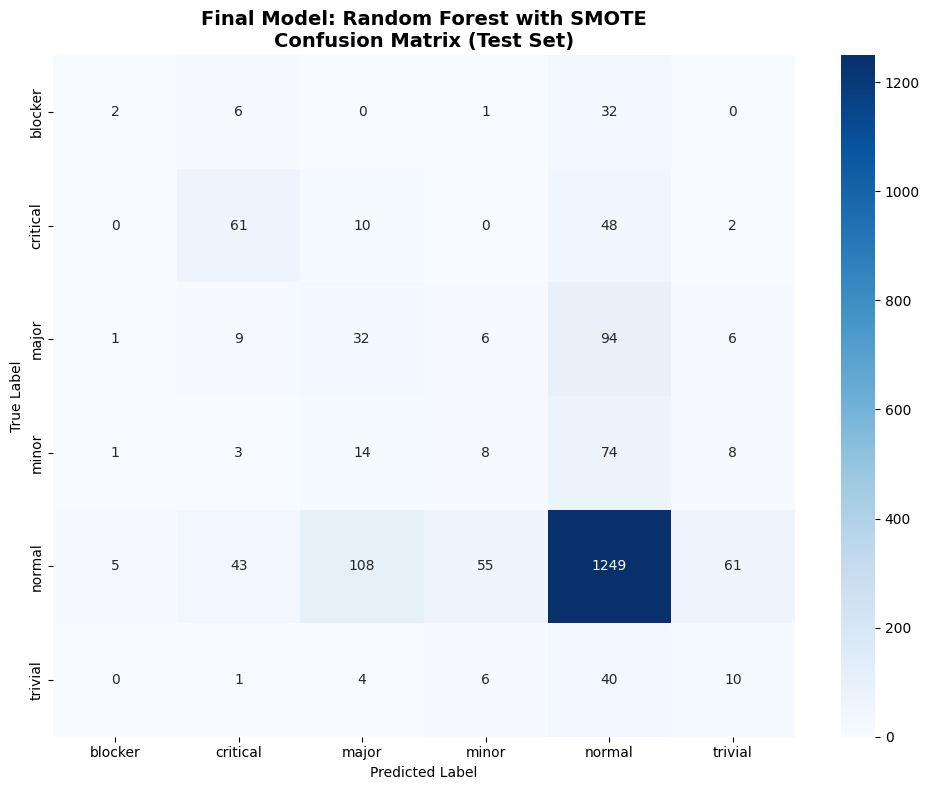

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(10,8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.title(f'Final Model: {best_model} with {best_approach}\nConfusion Matrix (Test Set)', 
          fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../figures/confusion_matrix_final.png', dpi=300, bbox_inches='tight')
plt.show()